In [154]:
# import libraries
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

#import daily SOFR data
sofr_spot_rates = pd.read_csv('C:/Users/kaibe/Documents/ETH_Zurich/Thesis/Data/SOFR.csv')
sofr_spot_rates = sofr_spot_rates.drop(sofr_spot_rates[sofr_spot_rates['SOFR'] == '.'].index)
sofr_spot_rates = sofr_spot_rates['SOFR'].astype(float)/100 #divide by 100 because data is in percent

dt = 1 / 252  #because daily data


ir = 0.05 #initial sofr
T = 1 #time horizon
N =  252 #number of time steps

#initial guess for parameters (k, theta, sigma)
initial_guess = [0.1, sofr_spot_rates.mean(), 0.1]

#function to simulate interest rate
def simulate_cir(k, theta, sigma, r0, T, N):

    #populate an empty array
    dt = T / N
    interest_rate_paths = np.zeros(N+1)
    interest_rate_paths[0] = r0 
    for t in range(1, N+1):
        Z = np.random.randn()
        r = interest_rate_paths[t-1]
        interest_rate_paths[t] = r + k * (theta-r) * dt + sigma * np.sqrt(dt) * np.sqrt(max(0, r)) * Z    
    return interest_rate_paths

def cir_log_likelihood(params, rates, dt):
    k, theta, sigma = params
    rt = rates[:-1]
    rt1 = rates[1:]
    drift = k * (theta - rt) * dt
    diffusion = sigma * np.sqrt(rt) * np.sqrt(dt)
    residuals = (rt1 - rt - drift) / diffusion
    log_likelihood = -np.sum(np.log(diffusion) + 0.5 * residuals**2)
    return -log_likelihood  #Minimize the negative log-likelihood

def pred_sofr(term):
    #Minimize the negative log-likelihood
    result = minimize(cir_log_likelihood, initial_guess, args=(sofr_spot_rates.values, dt),
                      bounds=[(1e-6, None), (1e-6, None), (1e-6, None)])
    
    k_est, theta_est, sigma_est = result.x

    #predict sofr
    series = simulate_cir(k_est, theta_est, sigma_est, ir, T, term * N)

    plt.plot(series)
    plt.show()

    sofr_per_year = []
    for i in range(term):
        sofr_per_year.append(series[(252*i):(252*(i+1)-(i+1))].mean())

    return series, sofr_per_year

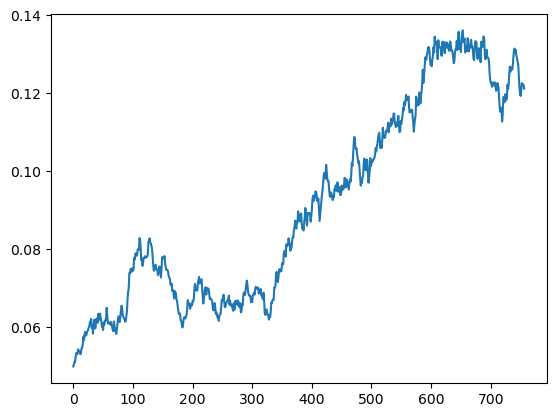

0.08323857049554113
0.08323857049554113


In [155]:
result, sofr_per_year = pred_sofr(3)
print(sofr_per_year[1])
print(np.mean(result[252:502]))
